# Figure 4 
<img src="parasitic_fold_proof_of_concept.svg">
Proof of concept 1-D example for parasitic fold geometry. (a) Reference fold shape : λ 1 = 15m
and λ 2 = 150m. and sampling locations (b) S-Plot showing fold rotation angle for fold in (a). (c) S-Variogram
for the structural observations, white dots in (a) and (b). The dots represent the variance for all points at
the corresponding step size. The red dots are the locations identified as being local extrema. The two esti-
mated half-wavelengths are shown by dashed lines. (d) Interpolated fold profile probability sampled using the
MCMC sample. (e) Interpolated fold rotation angle probability sampled by the MCMC sampler. (f) Violin
plot showing posterior and prior distribution for λ 1 and λ 2 .

In [1]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 18})
import matplotlib.pylab as plt
import numpy as np
from scipy.stats import norm
from fold import *
import pymc as pymc
import math
from bayesian_fourier_series import *
from Modified_Fold import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Running the code below will produce a figure similar to the one above. There will be some variations due to the noise added to simulate some geological uncertainty

In [8]:
#The x location of the data used in the paper has been saved in a numpy array, load this to reproduce the figures 
try:
    print "loading exisitng data"
    x = np.load('figure_4_x_location.npy')
except:
    x  = np.arange(0, 150,1)
    x = x[::2]
    print x
    np.random.shuffle(x)
    #N = 50
    #x = x[:N]
    print "generating data"

loading exisitng data
[  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142
 144 146 148]
generating data


In [9]:
np.save('figure_4_x_location',x)

In [4]:
wl1= 15.#15.
wl2 = 150.
x = x[:30]

#make parasitic fold with wl1 and wl2
foldfourier = fourierFold(30,30,wl1,0,40,20,0)
foldfourier2 = fourierFold(30,80,wl2,0,40,20,20)
foldr = foldRotation(foldfourier)
foldr2 = foldRotation(foldfourier2)
x_ = np.linspace(0,300,300)
#shape of the fold
fold= (foldfourier2.pos(x_))+foldfourier.pos(x_)
foldpts = (foldfourier2.pos(x))+foldfourier.pos(x)
#fold rotation angle is really the gradient of curve
foldrot = (np.gradient(fold))
mixture = True
xv = x#np.array([10.])
xm = np.array([20])
data = DataSet(xv,foldfourier2.pos(xv)+foldfourier.pos(xv),x,foldrot[x],xm,foldfourier2.pos(xm)+foldfourier.pos(xm),foldrot[xm]) 
x__ = x_

foldrot = np.arctan(np.gradient(fold))

foldrot*=180.0/np.pi

#a = np.random.choice([1,1,1,1,1,1,1],N)
#add a little bit of noise to the fold rotation angle
for i in range(1):
    xx1, yy1 = shake_xy(x,foldrot[x],5)
    fourierseries = bayesian_fourier_series_model(xx1,yy1,1)
fourierseries.add_reference_foldshape(x_,fold)
fourierseries.add_reference_foldlocations(x,foldpts)
fourierseries.add_reference_foldprofile(x_,foldrot)
fourierseries.find_wavelength()
print "estimated wavelengths", fourierseries.wavelengths
fourierseries.setup_inference()

46.08 167.04000000000002
estimated wavelengths [46.08, 167.04000000000002]


bayesian_fourier_series.py:385: UserWarning: Warning: converting a masked element to nan.
  variance[i] = np.mean(ma) / 2.


True

In [5]:
#run for 5000 iterations, discard half
fourierseries.run_sampler(5000,2500)

 [-----------------100%-----------------] 5000 of 5000 complete in 21.7 sec

True

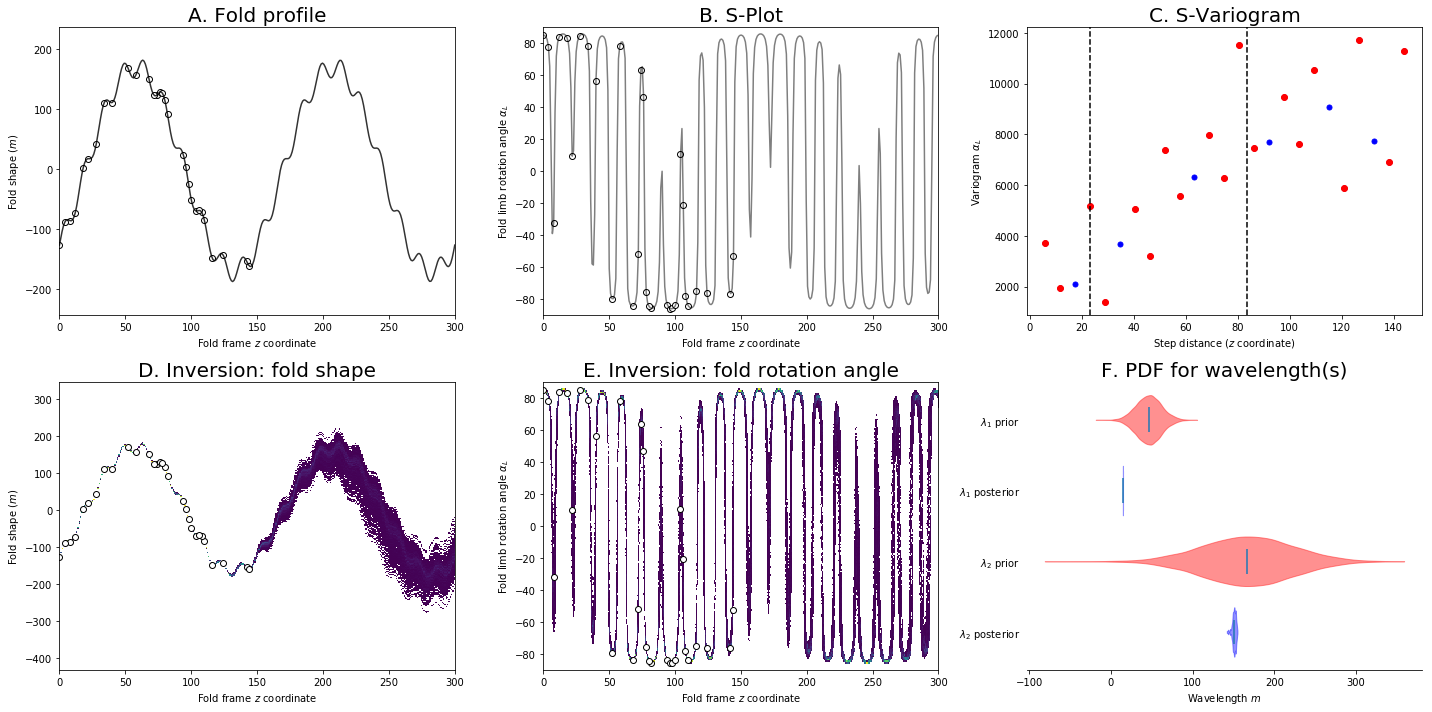

In [6]:
#make a nice figure
fig = bayesian_fourier_series_figure(fourierseries)
fig.plot_variogram()
fig.plot_reference_fold_points()
fig.plot_reference_fold_points('bo',0,1)

fig.plot_reference_fold_profile()
fig.plot_reference_fold_profile_points()
fig.plot_reference_fold_profile_points('bo',1,1)

fig.plot_reference_fold_shape()
fig.ax[0][0].set_title(r'A. Fold profile',fontsize=20)
fig.ax[0][1].set_title(r'B. S-Plot',fontsize=20)
fig.ax[0][2].set_title(r'C. S-Variogram',fontsize=20)

fig.ax[1][1].set_title(r'E. Inversion: fold rotation angle',fontsize=20)
fig.ax[1][0].set_title(r'D. Inversion: fold shape',fontsize=20)
fig.ax[1][2].set_title(r'F. PDF for wavelength(s)',fontsize=20)

fig.ax[0][0].set_xlabel(r'Fold frame $z$ coordinate')
fig.ax[0][1].set_xlabel(r'Fold frame $z$ coordinate')
fig.ax[0][2].set_xlabel(r'Step distance ($z$ coordinate)')

fig.ax[1][2].set_xlabel(r'Wavelength $m$')

fig.ax[0][1].set_ylabel(r'Fold limb rotation angle $\alpha_L$')
fig.ax[0][2].set_ylabel(r'Variogram $\alpha_L$')

fig.ax[1][0].set_xlabel(r'Fold frame $z$ coordinate')
fig.ax[1][0].set_ylabel(r'Fold shape ($m$)')
fig.ax[0][0].set_ylabel(r'Fold shape ($m$)')

fig.ax[1][1].set_xlabel(r'Fold frame $z$ coordinate')
fig.ax[1][1].set_ylabel(r'Fold limb rotation angle $\alpha_L$')
H2 = fig.plot_curve_density(0,300)
fig.plot_fold_heat_map(data)
colours = ['b-','r-']
temp = fig.ax[0][0]
i = 0

arrays = []
pos = []
labels = []
c = len(fourierseries.wavelengths)
for i in range(len(fourierseries.wavelengths)):
    arrays.append(np.random.normal(fourierseries.wavelengths[i],fourierseries.wavelengths[i]/3.,10000))
    labels.append(r"$\lambda_%i$ prior"%(i+1))
    pos.append(c)
    c-=1
    arrays.append(fourierseries.S.trace('qw_%i'%i)[:][:])
    labels.append(r"$\lambda_%i$ posterior"%(i+1))

    pos.append(c)
    c-=1
fig.plot_violin(1,2,labels,pos,arrays)
#plt.tight_layout()
for i in range(2):
    for j in range(2):
        fig.ax[i][j].set_xlim(0,300)
fig.ax[1][2].spines['top'].set_visible(False)
fig.ax[1][2].spines['right'].set_visible(False)
fig.ax[1][2].spines['left'].set_visible(False)
fig.ax[1][2].tick_params(top='off', bottom='on', left='off', right='off', labelleft='on', labelbottom='on')
plt.tight_layout()

In [48]:
fig.fig.savefig("parasitic_fold_proof_of_concept.svg")